# Tutorial: Diffusion Map Embedding & Label Transfer with **acdc_py**

Warning: to perform this tutorial, it is necessary to first run the ICS ACDC tutorial and save the resulting protein activity AnnData locally.

A **diffusion map** is a powerful nonlinear dimensionality reduction technique, particularly useful for capturing intrinsic structures in single-cell data. It's often used for visualization and pre-processing, especially when analyzing dynamic biological processes or subtle differences between cell states.

In many applications, we may have **reference single-cell data**—for example, from healthy tissue—and want to compare it to **query data**, such as cells from a diseased condition. A key question is: *how similar are the query cells to the reference cells in various embedding spaces, such as PCA, UMAP, or diffusion maps?*

Once both datasets are aligned in a common space, we can perform **label transfer**, propagating known annotations (e.g. cell types) from the reference to the query data. While **Scanpy’s `ingest`** function supports mapping and label transfer in PCA/UMAP space, it does not support **diffusion maps**, and its all-in-one design makes it hard to control mapping and label transfer independently.

**ACDC** addresses these limitations by providing:
- `acdc_py.tl.diffusion_reference_mapping`: a flexible diffusion map implementation with support for **Nyström extension** (query mapping)
- `acdc_py.tl.transfer_labels_anndata`: a modular, standalone **label transfer method** that can operate in any space, including the mapped diffusion space or PCA.

Both methods work with reference and query AnnData objects.

---

## In this hands-on tutorial, we’ll explore how to:

0. **Load an AnnData and split it into query and reference data**, to simulate a real case scenario.
1. **Compute diffusion map embeddings** on the reference data
2. **Project new (query) cells** onto the reference data via the Nyström extension  
3. **Transfer cell-type labels** learned with ACDC using a KNN classifier in the learned reference + mapped query space (diffusion space or PCA space)
4. **Evaluate the accuracy** of the label transfer method when ground truth labels for the query are available.

---

**Prerequisites:**  
- An environment with `acdc_py` installed  

Let’s get started!


## 1. Load Protein Activity Data
In the previous tutorial, we used ACDC to assign clusters to each cell in the protein activity AnnData. We split this AnnData into query and reference cells AnnDatas, to simulate a real world scenario in which some cells are labelled and some are not. Knowing the true labels of the query cells will allow us to evaluate the performance of the label transfer step.

Note: it is not necessary to use protein activity data to perform these steps. It can be run on scRNAseq or other modalities as well. 

In [1]:
import warnings
# Hide non-critical warnings for a cleaner notebook output
warnings.filterwarnings("ignore")

import numpy as np # Numerical computing
import scanpy as sc      # Single‑cell analysis framework
import acdc_py as acdc   # Our diffusion map & label‑transfer toolkit

In [2]:
!ls ../../acdc_py/Tutorials/output/pax_data.h5ad

../../acdc_py/Tutorials/output/pax_data.h5ad


In [3]:
# Load locally saved protein activity AnnData, saved locally after completing the ICS tutorial.
pax_data = sc.read_h5ad("../../acdc_py/Tutorials/output/pax_data.h5ad")

pax_data

AnnData object with n_obs × n_vars = 3656 × 3188
    obs: 'n_counts', 'ct_score', 'ct_pseudotime', 'ct_num_exp_genes', 'clusters', 'subclusters'
    uns: 'GS_results_dict', 'clusters_colors', 'gex_data', 'knn', 'louvain', 'neighbors', 'pca', 'subclusters_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'corr_dist'

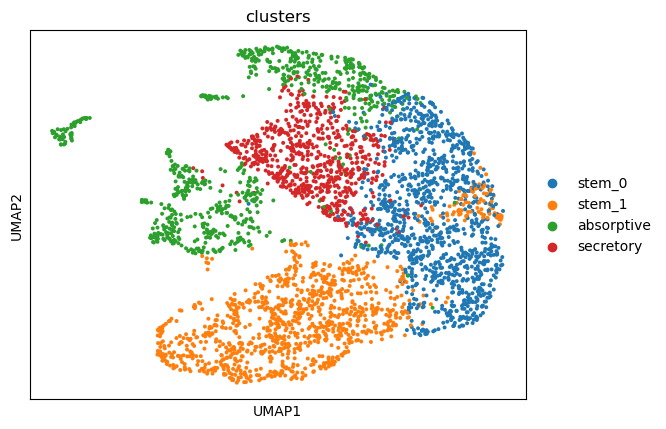

In [4]:
# We show the current UMAP of the protein AnnData (reference + query together) 
# with the ground truth labels obtained by running ACDC in the ICS tutorial.
sc.pl.umap(pax_data, color="clusters")

We split the protein activity AnnData into query and reference for demonstrative purposes.

In [5]:
# Set seed for reproducibility
seed = 42
np.random.seed(seed)

# Reference vs query cells split
cell_fraction = 0.8 # 80% reference cells, 20% query cells

# Get total number of cells
n_cells = pax_data.n_obs

# Shuffle and split indices
indices = np.random.permutation(n_cells)
split_point = int(n_cells * cell_fraction) 
ref_indices = indices[:split_point]
query_indices = indices[split_point:]

# Create reference and query AnnData objects
adata_ref = pax_data[ref_indices].copy()
adata_query = pax_data[query_indices].copy()


## 2. Compute Diffusion Map & Nyström Extension

In this step, we compute a **diffusion map embedding** on the reference dataset, and then **project the held-out query cells** into the same diffusion space using the **Nyström extension** method. This enables consistent visualization and downstream analysis of both datasets in a shared low-dimensional space.

The `acdc.tl.diffusion_reference_mapping()` function offers several tunable parameters:

- **`embedding_key="X"`**  
  Specifies the input representation used to compute the diffusion map.  
  Use `"X"` to apply the method directly to `.X`, or provide the name of a custom representation stored in `.obsm`.

- **`neigen=2`**  
  Number of diffusion components (dimensions) to compute. These serve as the coordinates in the resulting diffusion space.

- **`pca_comps=None`**  
  *(Optional)* Number of principal components to use for preprocessing before constructing the diffusion map.  
  Reducing dimensionality via PCA can speed up computation.

- **`plot=True`:** 
*(Optional)* You can visualize the reference and query cells together in the resulting diffusion space by setting to `True`.


Computing diffusion map (2 components) on reference...
Extending to query via Nyström extension...


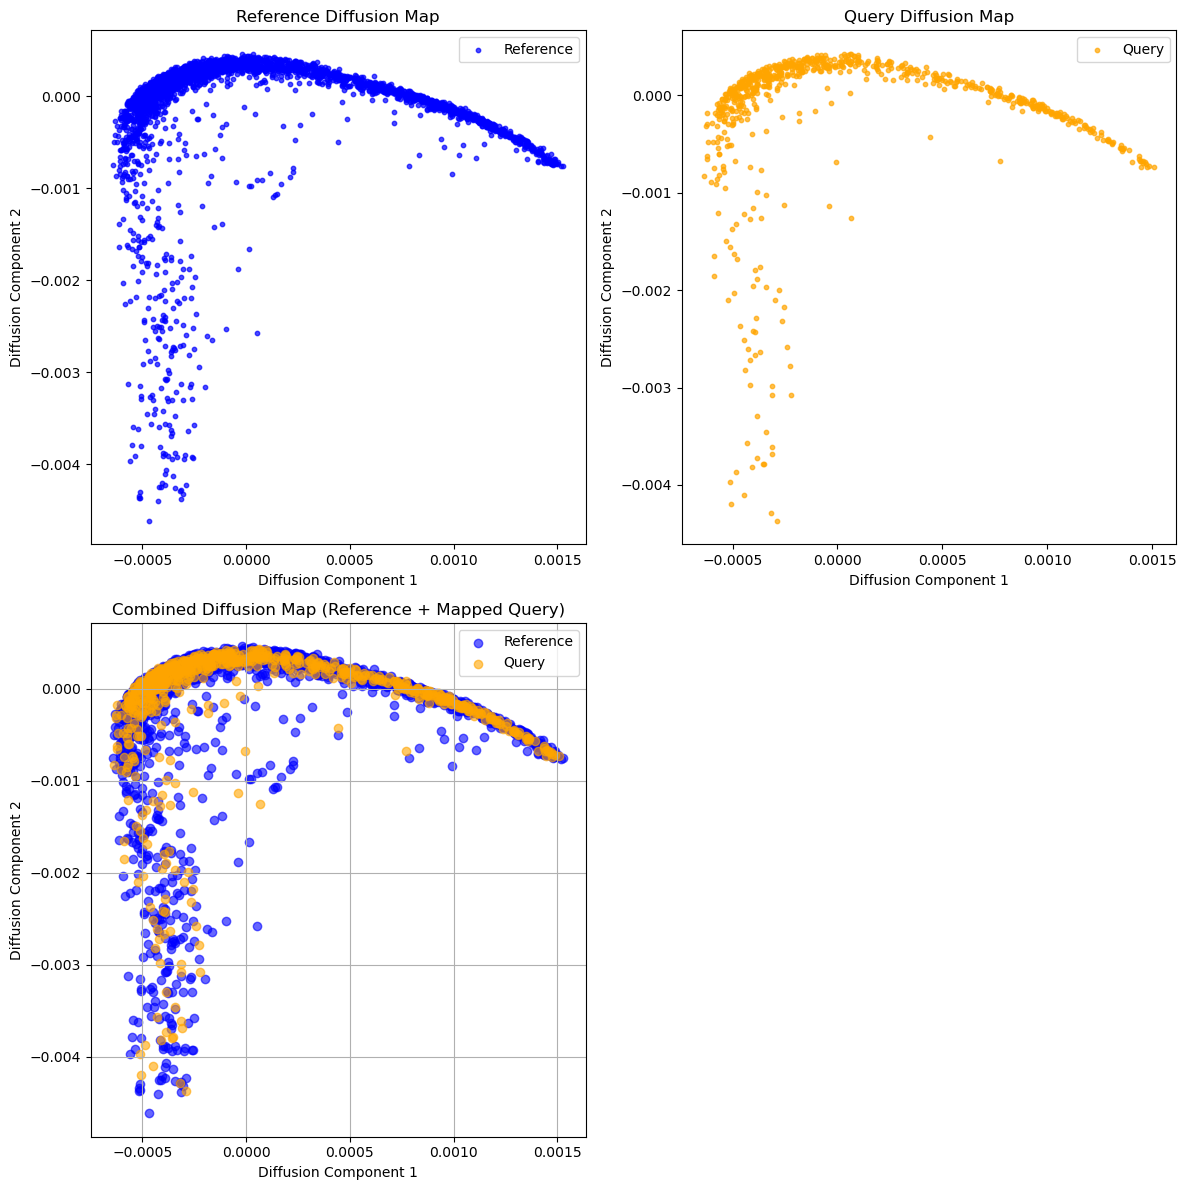

Stored embeddings in .obsm['X_diffmap'] and details in .uns['diffusion_results'].


In [6]:
acdc.tl.diffusion_reference_mapping(
    adata_ref, # Reference AnnData    
    adata_query, # Query AnnData
    embedding_key="X", # Input reference representation to the diffusion map dimensionality reduction.
    neigen=2, # Number of output dimensions in diffusion space         
    pca_comps=30, # Number of PCA components to apply to input data before running diffusion map     
    plot=True # Whether to plot the reference+mapped query 2D diffusion coordinates or not          
)

### Interpreting the Diffusion Map Plot

Here, we visualize the first two diffusion components, showing reference and query cells separately (first row) and in the same low-dimensional space (second row). This allows us to inspect how well the query cells were mapped to the reference structure.

However, this is only the **first step** in evaluating mapping quality. The **next step** is to check whether the transferred labels on the query match their original (ground truth) labels — providing a more objective measure of alignment accuracy.


## 3. Transfer Labels from Reference to Query

Once the query cells have been mapped into a common embedding space (e.g. diffusion map or PCA), we can transfer labels from the reference dataset using a **K-nearest neighbors classifier**.

The `acdc.tl.transfer_labels_anndata()` function performs this label transfer and optionally evaluates prediction accuracy if ground-truth labels are available.

### Key Parameters:

- **`embedding_key="X_diffmap"`**  
  Specifies the space in which to perform KNN label transfer. Only `X_diffmap`, `X_pca` or `X` are supported, which correspond to the diffusion map space, PCA space, or the original gene expression (here, protein activity) space. We suggest to use either `X_pca` or `X_diffmap` for speed and performance.

- **`pca_comps=None`**  
  *(Optional)* Number of PCA components to compute before label transfer. If a number is provided, and the embedding key is set on `X_pca`, PCA will be computed de novo on the reference using specified components and query cells will be mapped onto the reference using the PCA loadings (components) before running label transfer. If left as `None`, the function expects `X_diffmap` or `X` as the embedding key. This argument will be ignored unless the embedding key is set on `X_pca`.

- **`label_key="leiden"`**  
  The key in `ref_adata.obs` that contains the labels to transfer (e.g., cell clusters or types).

- **`n_neighbors=15`**  
  The number of neighbors used in the KNN classifier.

- **`ground_truth_label="true_leiden"`**  
  *(Optional)* If provided, the accuracy of transferred labels is computed by comparing them to known labels in `query_adata.obs[ground_truth_label]`.

- **`plot_labels=True`**  
  Visualizes the predicted vs. ground-truth labels using the selected embedding.

Labels transferred to query .obs['transf_clusters'] using X_diffmap embedding.
Accuracy against 'clusters': 0.90


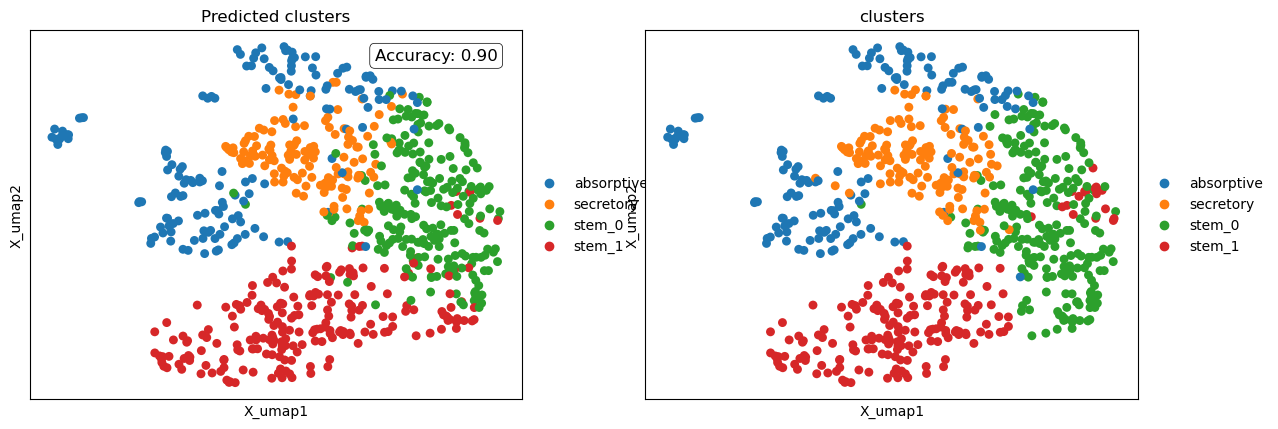

In [7]:
acdc.tl.transfer_labels(
    ref_adata=adata_ref, # Reference AnnData            
    query_adata=adata_query, # Query AnnData
    embedding_key='X_diffmap', # Either X_pca, X_diffmap, or X  
    pca_comps=15, # Use with embedding_key='X_pca' to run query to ref mapping using PCA                 
    label_key='clusters', # Label key in reference AnnData              
    n_neighbors=15, # k in k-NN classifier. Determines the resolution of the label transfer.                
    ground_truth_label="clusters", # If ground truth available, it will be used to assess label transfer accuracy
    plot_labels=True, # Plot ground truth and predicted labels of the query if ground truth is available
    plot_embedding_key="X_umap"  # Choose the representation for plotting the query AnnData        
)

### Interpreting Label Transfer Outcomes 

We can assess the quality of the query-to-reference mapping in two ways:

- **Qualitatively**, by visually comparing the predicted labels (transferred from the reference) with the ground truth labels on the UMAP plot.
- **Quantitatively**, by reviewing the printed accuracy score.

In this example, label transfer was performed in the **diffusion map space**, resulting in an **accuracy of 90%**. This means that out of every 100 query cells, 90 were assigned the correct cluster label based on their position in the mapped space. 